<a href="https://colab.research.google.com/github/fernando2393/DT2119-Final-Project/blob/Andres_V2/MusicGenreClassification_Andres_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [9]:
from google.colab import files
files.upload()

Saving constants.py to constants (1).py
Saving features.py to features (1).py
Saving loader.py to loader (1).py


{'constants.py': b'# # Run locally\r\n# DATASETS = "Datasets/fma_small/"\r\n# METADATA = "Datasets/fma_metadata/"\r\n# MFCC = "Datasets/mfcc.csv"\r\n# SPECTROGRAM = "Datasets/spectrogram.csv"\r\n\r\n# Run on Google Colab\r\nDATASETS = "/content/drive/My Drive/Datasets_new/fma_small/"\r\nMETADATA = "/content/drive/My Drive/Datasets_new/fma_metadata/"\r\nMFCC = "/content/drive/My Drive/Datasets_new/mfcc.csv"\r\nSPECTROGRAM = "/content/drive/My Drive/Datasets_new/spectrogram.csv"\r\n',
 'features.py': b'import pandas as pd\r\nimport sklearn\r\nimport librosa.display\r\nimport librosa\r\nimport os\r\nfrom tqdm import tqdm\r\nimport warnings\r\nimport constants as cts\r\nimport numpy as np\r\n\r\n\r\ndef compute_feature(mode, filepath):\r\n    """\r\n    This method loads the a music track and computes the mfcc.\r\n    :param mode: allows to get either spectrogram or mfcc.\r\n    :param filepath: music track.\r\n    :return mfcc of the data track.\r\n    """\r\n    if mode == \'spectrogram\

In [4]:
import loader
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

Using TensorFlow backend.


In [0]:
def plot_history(history):

    fig, axs = plt.subplots(2)
    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    plt.show()

In [0]:
def predict(model, x, y):
    prediction = model.predict(x)
    predicted_index = np.argmax(prediction, axis=1)
    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [10]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = loader.get_train_val_test(mode='spectrogram')
print("There are the following classes:")
classes = set(y_train.tolist()) & set(y_val.tolist()) & set(y_test.tolist())
print(classes)

Calculating spectrogram...


FileNotFoundError: ignored

In [0]:
# Remove small samples
x_train = np.delete(x_train, [3495, 3496, 3497])
y_train = np.delete(y_train, [3495, 3496, 3497])
x_train = np.rollaxis(np.dstack(x_train), -1)
x_val = np.rollaxis(np.dstack(x_val), -1)
x_test = np.rollaxis(np.dstack(x_test), -1)
# x_train = np.expand_dims(x_train, axis=3)
# x_val = np.expand_dims(x_val, axis=3)
# x_test = np.expand_dims(x_test, axis=3)

print(x_train.shape)
print(x_train.shape[1:])

In [0]:
# One-hot encoding of classes
dict_labels = {'Electronic': 0, 'Experimental': 1, 'Folk': 2, 'Hip-Hop': 3,
                'Instrumental': 4, 'International': 5, 'Pop': 6, 'Rock': 7}
y_train = [dict_labels[y_train[i]] for i in range(y_train.shape[0])]
y_val = [dict_labels[y_val[i]] for i in range(y_val.shape[0])]
y_test = [dict_labels[y_test[i]] for i in range(y_test.shape[0])]
y_train = to_categorical(y_train, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)



In [0]:
def conv_layer(inputs, filters, kernel_size, pool_size):
    x = Conv1D(filters, kernel_size)(inputs)
    x = tf.nn.relu(x)
    x = MaxPooling1D(pool_size=pool_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.4)(x)

    return x

In [0]:
class Classifier:

    @staticmethod
    def build(inputs, classes, layers, filters, kernel_size, pool_size):
        # Convolutional layers
        x = inputs
        for i in range(layers):
            x = conv_layer(x, filters[i], kernel_size[i], pool_size[i])
        x = tf.keras.layers.LSTM(96, return_sequences=False)(x)
        x = Dropout(0.4)(x)
        
        
        # Final layer
        
        # Dense Layers
        x = Flatten()(x)
        x = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation='relu')(x)
        x = Dropout(rate=0.3, trainable=True)(x)
        
        # Global Pooling
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        
        
        outputs = Dense(classes, activation='softmax', kernel_regularizer=l2(0.01))(x)




        return tf.keras.Model(inputs=inputs, outputs=outputs)

In [0]:
def build_model_Conv1D(input_shape):
    model = keras.Sequential()
    # 1st conv layer
    model.add(keras.layers.Conv1D(32, 4, activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling1D(pool_size=4, strides=2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 2nd conv layer
    model.add(keras.layers.Conv1D(32, 2, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 3rd conv layer
    model.add(keras.layers.Conv1D(32, 2, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(keras.layers.BatchNormalization())

    # Dense layer
    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # # Global Average Pooling
    # model.add(keras.layers.GlobalAveragePooling1D())
    # # model.add(keras.layers.Flatten())
    
    # output layer
    # model.add(keras.layers.Dense(8, activation='softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activity_regularizer=l2(0.01)))
    model.add(keras.layers.Dense(8, activation='softmax', kernel_regularizer=l2(0.01)))

    return model

In [0]:
# Training parameters
epochs = 50  # Train for 25 epochs
lr = 0.0005  # Initial learning rate
batch_size = 16

inputs = tf.keras.Input(shape=x_train.shape[1:])
layers = 3
# filters = [56, 56, 56]
# kernel_size = [5, 5, 5]
# pool_size = [2, 2, 2]
filters = [32, 32, 32]
kernel_size = [4, 2, 2]
pool_size = [4, 2, 2]
stride_size = [2, 2, 2]

In [20]:
model = Classifier.build(inputs, 8, layers, filters, kernel_size, pool_size)
print("Summary:")
print(model.summary())

opt = Adam(learning_rate=lr)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# Callbacks: early stopping and checkpoint
early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1,
                                patience=10,
                                mode='max',
                                restore_best_weights=True)
filepath = "weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                              save_best_only=True, mode='max')
callbacks_list = [checkpoint, early_stopping]


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 29, 32)            60704     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 32)            128       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 14, 32)            2080      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 32)             128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 6, 32)            

Train on 6394 samples, validate on 800 samples
Epoch 1/30
6394/6394 [==============================] - 6s 889us/step - loss: 2.4739 - accuracy: 0.1420 - val_loss: 2.3475 - val_accuracy: 0.1350
Epoch 2/30
6394/6394 [==============================] - 5s 786us/step - loss: 2.1716 - accuracy: 0.2222 - val_loss: 3.3433 - val_accuracy: 0.1462
Epoch 3/30
6394/6394 [==============================] - 5s 788us/step - loss: 2.0824 - accuracy: 0.2596 - val_loss: 2.0629 - val_accuracy: 0.2637
Epoch 4/30
6394/6394 [==============================] - 5s 791us/step - loss: 2.0204 - accuracy: 0.2768 - val_loss: 2.1191 - val_accuracy: 0.2062
Epoch 5/30
6394/6394 [==============================] - 5s 789us/step - loss: 1.9691 - accuracy: 0.3037 - val_loss: 2.0608 - val_accuracy: 0.2562
Epoch 6/30
6394/6394 [==============================] - 5s 790us/step - loss: 1.9421 - accuracy: 0.3189 - val_loss: 2.0185 - val_accuracy: 0.3063
Epoch 7/30
6394/6394 [==============================] - 5s 790us/step - loss:

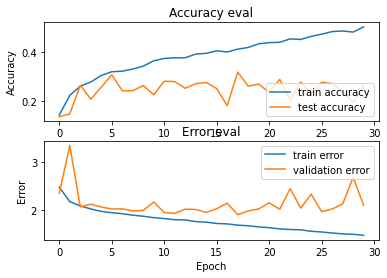

In [21]:
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list,
                    epochs=epochs, verbose=1)


plot_history(history)

In [22]:
# Evaluate the model on the test data using `evaluate`
print("Evaluating model on test data...")
results = model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test loss:", results[0])
print("Test acc:", results[1])

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Evaluating model on test data...
800/800 [==============================] - 0s 293us/step
Test loss: 2.107238655090332
Test acc: 0.28125

Test accuracy: 0.28125
